# So a Robot Walks into a Bar...

## Beers Have Style
Schwartzbier, real ale, wheat beer, Kölsch... many things can define a beer's style. In the professional brewing world, styles are typically differentiated by appearance, flavor, ingredients, production method, history, or origin. Unfortunately, not everyone agrees on how to categorize beer styles, and brewers often flip flop their beers between categories for competitions and distributors in different parts of the world. For instance, take a look at differences between CAMRA's Champion Beer of Britain, the Beer Judge Certification Program (BJCP), the Brewers Association's World Beer Cup). Furthermore, new styles are invented all the time as breweries try to differentiate their creations, and angsty beer geeks are given reason to wage sudsy wars in online forums. But even the most time-honored styles were once new (even lagers were invented less than 200 years ago). Our preferences both shape and are shaped by this long, organic process.

Meanwhile, back at the brewery, a brewer is mindfully formulating and testing beer according to precise scientific standards. This precision ensures that a Sierra Nevada Pale Ale tastes just as good no matter when or where you drink it. The subjective qualities of beer styles are transformed. Color is identified according to the Standard Reference Method (SRM), bitterness is quantified on the scale of International Bitterness Units (IBUs), and a beer's capacity for danger and fun is measured by its alcohol content (percentage of alcohol by volume, or ABV). Many other metrics exist, but these are the big three. Give a Certified Cicerone (beer sommelier) these three pieces of information, and he or she could probably tell you its style without even tasting it.

## Beer by Numbers
Robots are taking over the world, if you haven't noticed. Once they're fed the right data, they can make independent decisions. That got me thinking... if I fed a robot beer data and asked it to come up with its own style categories, what would they look like? Can styles be determined quantitatively, based on SRM, IBU, and ABV alone?

## Categorizing Beer Styles with Machine Learning
Data science provides the tools to gather this beer data and feed it to a robot (i.e., a computer). Asking the computer to find structure within a collection of unlabeled data perfectly describes an unsupervised machine learning problem. We'll provide a long list of beers' SRM, IBU, and ABV metrics, and see if the computer can differentiate different categories, or "clusters", of beer. [Python 3.5](https://python.org) is my preferred language for data analysis because of its wide variety of powerful, open-source packages. 

PS -- To learn more about clustering methods, check out this tutorial from the [Polytechnic Institute of Milan](https://home.deib.polimi.it/matteucc/Clustering/tutorial_html/).

## The Analysis
I assume you're not here to get slapped with lines of code, so I streamlined this analysis by making a Python package called <tt>bdb_utils</tt>. Don't worry, the fun stuff is still on this page. But feel free to look into <tt>bdb_utils</tt> on [my Github page](https://github.com/mrstepanovic/suds/blob/master/bdb_utils.py).

### Collecting Data
Beer data was collected from [BreweryDB](http://www.brewerydb.com/)'s web API, a moderated, crowd-sourced database of beer releases in development since 2009. I've been playing with it for just about three weeks and love it for its squeaky-clean data. 

In [3]:
import pandas as pd
import numpy as np
import bdb_utils
import requests
import json

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [278]:
# Add your API key here.
API_KEY = "c7638c9e8a98b169c092481ba409bd9f"
URL = "http://api.brewerydb.com/v2/beers/"

# Set parameters for BreweryDB's API.
params = dict(key=API_KEY, withBreweries='Y')

# Attempt to download 10,000 randomly-chosen beers from the database.
beer_data = bdb_utils.download_data(URL, params, 1000000, False)
beer_data.to_csv("beer_data_10k.csv")

In [279]:
# Save dataframe as a .csv for offline analysis.
beer_data.to_csv("beer_data_5k.csv")

### Exploring the Data

How many unique beers and styles were collected?

In [284]:
number_of_beers = beer_data['Beer Name'].nunique()
number_of_styles = beer_data['Style'].nunique()

print("{} beers of {} styles were collected.".format(number_of_beers, number_of_styles))

5186 beers of 146 styles were collected.


What are the top 10 most popular styles?

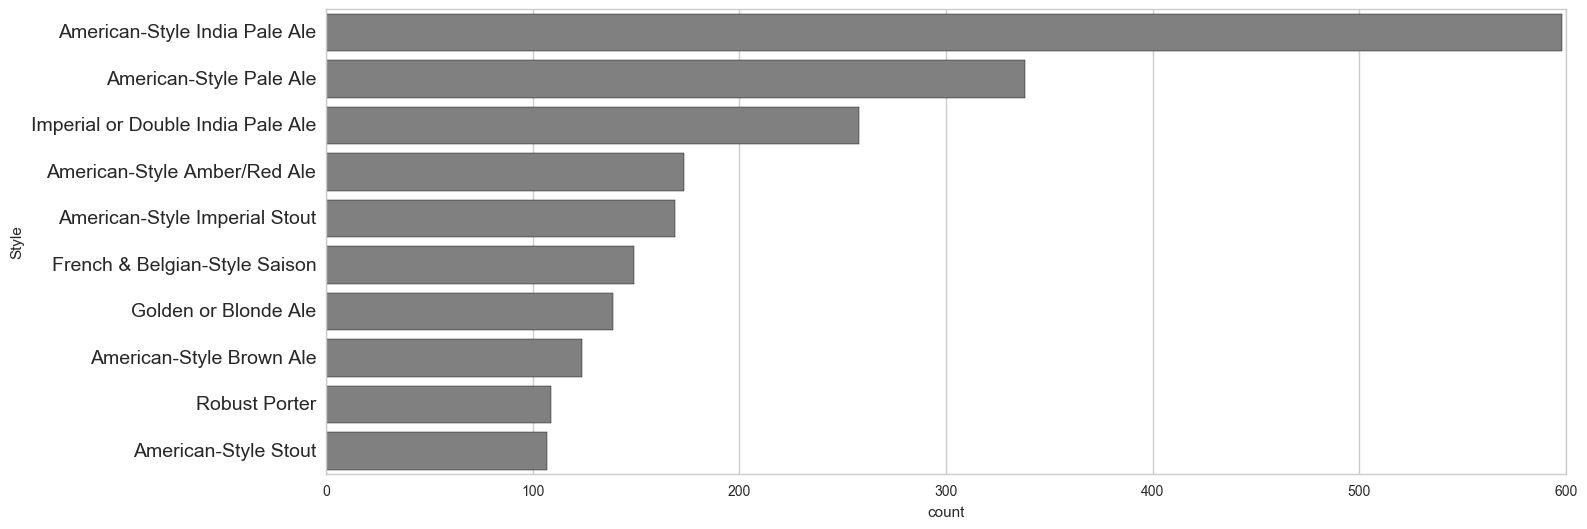

In [427]:
sns.set_style("whitegrid")

fig1 = plt.figure(figsize=(16, 6))
ax = sns.countplot(y="Style", 
                   data=beer_data, 
                   color='gray',
                   order=pd.value_counts(beer_data['Style']).iloc[:10].index)

ax.set_yticklabels(ax.get_yticklabels(), fontsize=14);

American IPAs dominate the dataset by a landslide, followed by pale ales and imperial/double IPAs. I'm assuming that most contributors to BreweryDB are American, and beer-conscious Americans have a hop obsession. [But they don't have to](http://www.sfexaminer.com/stop-pretending-like-ipas/) ;)

What is the distribution of each beer metric?

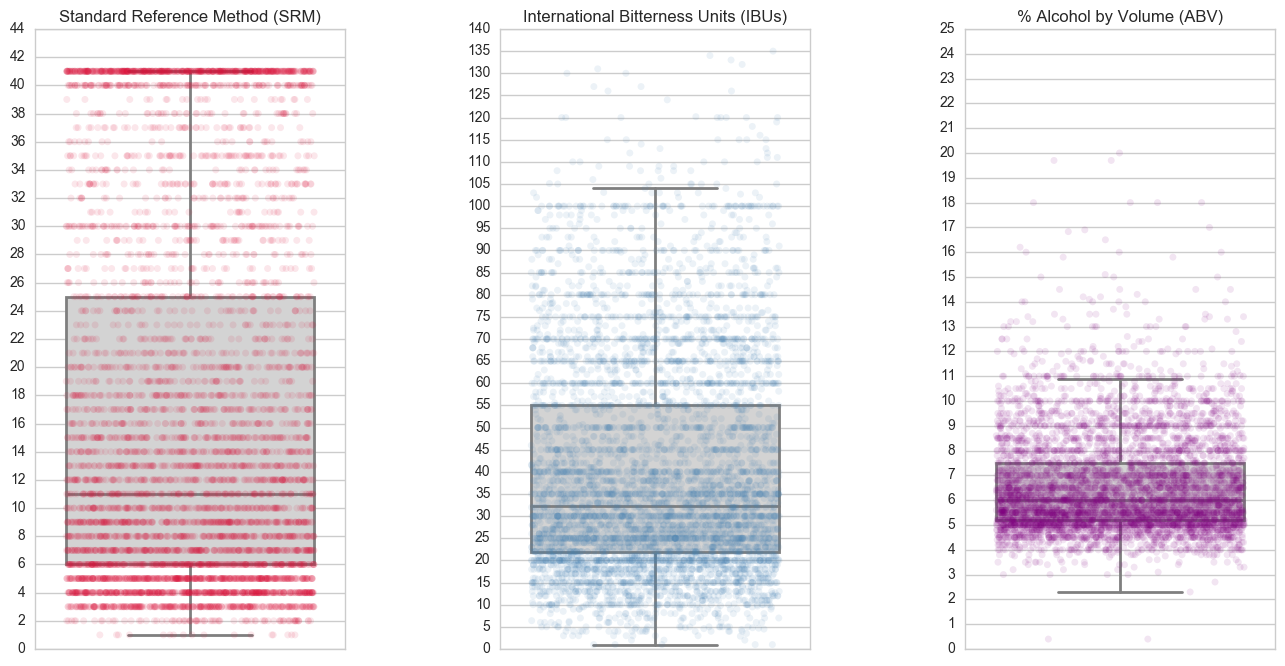

In [432]:
sns.set_style("whitegrid")

fig2, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(16,8))
fig2.subplots_adjust(wspace=0.5)

for ax in [ax1, ax2, ax3]:
    ax.yaxis.label.set_visible(False)

def make_boxplot(column, axis, color='lightgray', df=beer_data):
    sns.boxplot(data=df, 
                y=column, 
                ax=axis, 
                color=color, 
                linewidth=2, 
                width=0.8, 
                showfliers=False)

def make_stripplot(column, axis, color='purple', df=beer_data):
    sns.stripplot(data=df, 
                  y=column,
                  ax=axis, 
                  jitter=.4, 
                  color=color, 
                  size=5,  
                  alpha=.1)

ax1.set(ylim=(0, 44), yticks=(np.arange(0, 45, 2)), title="Standard Reference Method (SRM)")
make_boxplot("SRM", ax1)
make_stripplot("SRM", ax1, color='crimson')

ax2.set(ylim=(0, 140), yticks=(np.arange(0, 141, 5)), title="International Bitterness Units (IBUs)")
make_boxplot("IBU", ax2)
make_stripplot("IBU", ax2, color='steelblue')

ax3.set(ylim=(0, 25), yticks=(np.arange(0, 26, 1)), title="% Alcohol by Volume (ABV)")
make_boxplot("ABV", ax3)
make_stripplot("ABV", ax3, color='purple')

These visualizations reveal an asymmetric distribution in each of the big three beer metrics. Unlike IBU and ABV, SRM is an interval variable with discrete values between 2 and 41. 

## Clustering
* discuss k-means
* show elbow plot or silhouette plots for determining ideal number of clusters
* show k-means implementation with scikit-learn

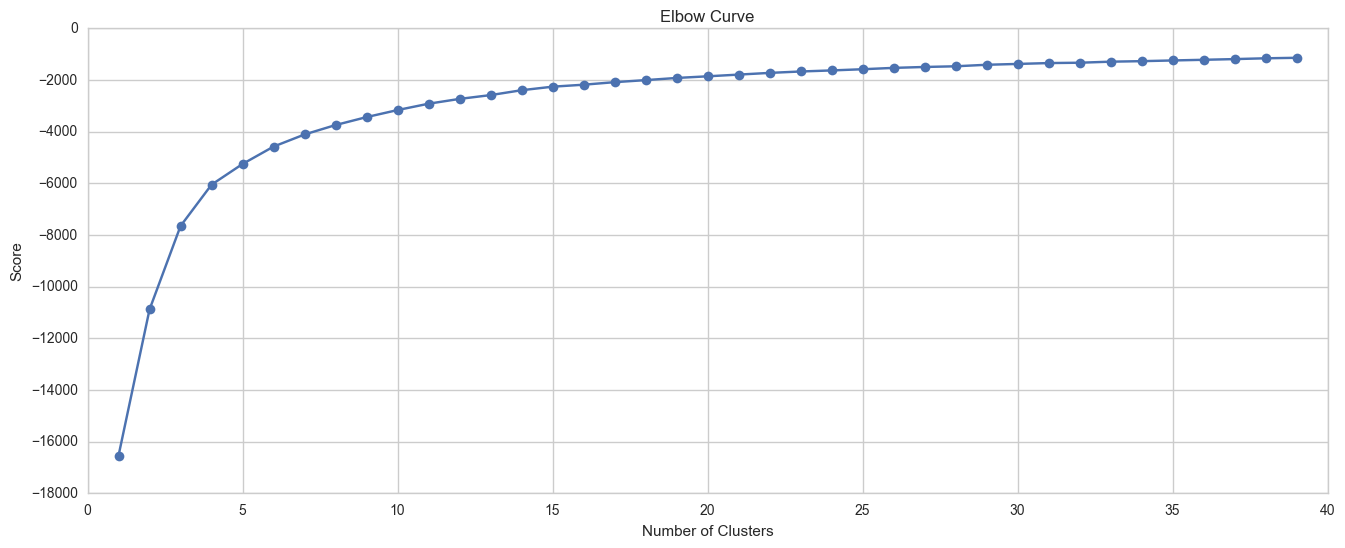

In [381]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

beer_measures = beer_data.as_matrix(columns=['SRM', 'IBU', 'ABV'])
X = StandardScaler().fit_transform(beer_measures)

k = range(1, 40)
kmeans = [KMeans(n_clusters=i) for i in k]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]

fig = plt.figure(figsize=(16, 6))
plt.plot(k, score, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')

In [416]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=20).fit(X)
n_clusters_ = len(set(db.labels_)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 7


## Results
* Show clusters colorized
  * 3D space?
* List styles in each cluster

In [421]:
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

k = 7
colors = ["green", "red", "blue", "gold", "aqua", "orange", 
          "violet", "salmon", "wheat", "lime", "chartreuse", "crimson"]

def make_cluster_points(name, cluster_df, color):
    return dict(mode="markers", 
                name=name, 
                type='scatter3d',
                text=cluster_df.as_matrix()[:,2],
                x=cluster_df.as_matrix()[:,5], 
                y=cluster_df.as_matrix()[:,4], 
                z=cluster_df.as_matrix()[:,3],
                marker=dict(size=4, color=color))

def make_cluster_mesh(name, cluster_df, color):
    return dict(alphahull=0,
                name=name,
                opacity=0.1,
                type="mesh3d",    
                x=cluster_df.as_matrix()[:,5], 
                y=cluster_df.as_matrix()[:,4], 
                z=cluster_df.as_matrix()[:,3],
                color=color,
                showscale=False)

beer_measures = beer_data.as_matrix(columns=['SRM', 'IBU', 'ABV'])
X = StandardScaler().fit_transform(beer_measures)

k_est = KMeans(n_clusters=k)
k_est.fit(X)

beer_data['cluster'] = k_est.labels_

clusters = {}
points = {}
meshes = {}

for x in range(k):
    clusters[x] = beer_data.loc[beer_data['cluster'] == x]
    points[x] = make_cluster_points("Cluster {}".format(x+1), clusters[x], colors[x])
    meshes[x] = make_cluster_mesh("Cluster {}".format(x+1), clusters[x], colors[x])

camera = dict(up=dict(x=0, y=0, z=1), 
              center=dict(x=0, y=0, z=0), 
              eye=dict(x=-1.6, y=-1.6, z=1))

layout = go.Layout(scene = dict(xaxis = dict(range = [0,45], title='SRM'),
                                yaxis = dict(range = [0,150], title='IBU'),
                                zaxis = dict(range = [0,30], title='ABV'),
                                camera=camera),
                                margin=dict(r=20, l=20),
                   width=800, height=800, showlegend=False)

plotted = [points[x] for x in points]
plotted.extend([meshes[x] for x in meshes])

fig2 = go.Figure(data=plotted, layout=layout)

plotly.offline.iplot(fig2)

## Discussion
* Robots don't see x, they see y
* These results are fascinating, but they reveal that there's a profound human element to beer's role in the world.
* Code available on Github

## Post to Social Media